<a href="https://colab.research.google.com/github/selfint/ai-research/blob/main/ForwardGradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy pandas matplotlib tqdm

In [ ]:
%matplotlib inline

from typing import List
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm
import seaborn as sns
sns.set_theme(style="darkgrid")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  # Remove the CWD from sys.path while we load stuff.


# Define Dual number class

## Calculate dual number exponents

For dual numbers, for any function we know that:

\begin{align*}
f(a+b\epsilon) = f(a) + f'(a)b\epsilon
\end{align*}

So if:

\begin{align*}
f(x) = e^{x}
\end{align*}

Then

\begin{align*}
f'(x) = e^{x}
\end{align*}

And finally:

\begin{align*}
e^{a+b\epsilon} = f(a+b\epsilon) = f(a) + f'(a)b\epsilon = e^a +e^ab\epsilon
\end{align*}


## Calculate dual number natural logs

Again, for dual numbers, for any function we know that:

\begin{align*}
f(a+b\epsilon) = f(a) + f'(a)b\epsilon
\end{align*}

So if:

\begin{align*}
f(x) = \ln(x)
\end{align*}

Then

\begin{align*}
f'(x) = \frac{1}{x}
\end{align*}

And finally:

\begin{align*}
\ln(a+b\epsilon) = f(a+b\epsilon) = f(a) + f'(a)b\epsilon = \ln(a) + \frac{b}{a}\epsilon
\end{align*}

As with normal logarithms
\begin{align*}
a \ne 0
\end{align*}

But the ε part can be any value!

In [ ]:
# naive dual number implementation
class Dual:
    epsilon_char = "ε"

    def __init__(self, a: float, b: float):
        assert not isinstance(a, Dual), "a is Dual"
        assert not isinstance(b, Dual), "b is Dual"

        self._a = a
        self._b = b

    def __mul__(self, other):
        if isinstance(other, Dual):
            return Dual(self._a * other._a, self._a * other._b + self._b * other._a)
        elif isinstance(other, np.ndarray):
            return other * self

        return Dual(self._a * other, self._b * other)

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        if isinstance(other, Dual):
            a, b, c, d = self._a, self._b, other._a, other._b

            assert c != 0, "Div by zero error"
            return Dual(a / c, (b * c - a * d) / (c * c))

        assert other != 0, "Div by zero error"
        return Dual(self._a / other, self._b / other)

    def __rtruediv__(self, other):
        assert self.real != 0, "Div by zero error"

        if isinstance(other, Dual):

            return other / self

        return Dual(other, 0) / self

    def __add__(self, other):
        if isinstance(other, Dual):
            return Dual(self._a + other._a, self._b + other._b)

        return Dual(self._a + other, self._b)

    def __radd__(self, other):
        return self + other

    def __gt__(self, other):
        if isinstance(other, Dual):
            return self.to_tuple() > other.to_tuple()

        return self._a > other

    def __eq__(self, other):
        if isinstance(other, Dual):
            return self.to_tuple() == other.to_tuple()

        return False

    def __lt__(self, other):
        if isinstance(other, Dual):
            return self.to_tuple() < other.to_tuple()

        return self._a < other

    def __ge__(self, other):
        return self > other or self == other

    def __le__(self, other):
        return self < other or self == other

    def __sub__(self, other):
        return self + (other * -1)

    def __rsub__(self, other):
        return other + (self * -1)

    def __neg__(self):
        return self * -1

    @property
    def real(self):
        return self._a

    @property
    def eps(self):
        return self._b

    def to_tuple(self):
        return self._a, self._b

    def __repr__(self):
        return f"{self._a} {self._b}{self.epsilon_char}"

    # numpy exp and log support:
    def exp(self):
        return Dual(np.exp(self.real), np.exp(self.real) * self.eps)

    def log(self):
        assert self.real != 0, "Div by zero error"

        return Dual(np.log(self.real), self.eps / self.real)

# numpy array helpers
to_dual_real = np.vectorize(lambda x: Dual(x, 0))
to_dual_eps = np.vectorize(lambda x: Dual(0, x))
dual_real = np.vectorize(lambda x: x.real)
dual_eps = np.vectorize(lambda x: x.eps)

# make sure Dual plays nicely with ndarray
print(to_dual_real([0, 0]) * Dual(0, 0))
print(Dual(0, 0) * to_dual_real([0, 0]))
print(to_dual_real([0, 0]) * to_dual_real([0, 0]))

[0 0ε 0 0ε]
[0 0ε 0 0ε]
[0 0ε 0 0ε]


# very simple neural network implementation

In [ ]:
def init_theta(sizes: List[int]):
    layers = []
    for prev_size, size in zip(sizes, sizes[1:]):
        w = np.random.rand(prev_size, size) / 10 - 0.05
        b = np.random.rand(size) / 10 - 0.05

        layers.append((w, b))

    return layers

def concat_theta(theta, sizes):
    flat_layers = []

    for w, b in theta:
        flat_layers.append(w.flatten().reshape(-1, 1))
        flat_layers.append(b.flatten().reshape(-1, 1))

    return np.concatenate(flat_layers)

def parse_theta(theta, sizes: List[int]):
    layers = []

    prev_end = 0
    for prev_size, size in zip(sizes, sizes[1:]):
        w_end = prev_end + prev_size * size
        b_end = w_end + size

        w = theta[prev_end:w_end].reshape(prev_size, size)
        b = theta[w_end:b_end].reshape(size)

        layers.append((w, b))
        prev_end = b_end

    return layers

def build_theta(sizes: List[int]):
    return concat_theta(init_theta(sizes), sizes)

# test packing/unpacking is correct
sizes = 5, 4, 3, 2, 1
_theta = init_theta(sizes)
_c_theta = concat_theta(_theta, sizes)
_p_c_theta = parse_theta(_c_theta, sizes)
[(_theta[i][j] == _p_c_theta[i][j]).all() for i in range(len(_theta)) for j in range(len(_theta[i]))]


[True, True, True, True, True, True, True, True]

In [ ]:
# activations

def relu_(transfer):
    return 0.01 * transfer if transfer < 0 else transfer

relu = np.vectorize(relu_)

def sigmoid(transfers: np.array) -> np.array:
    return 1 / (1 + np.exp(-transfers))

def softmax(transfers: np.array) -> np.array:
    stable = transfers - transfers.max()
    exponents = np.exp(stable)
    exponents_sum = exponents.sum()
    softmax = exponents / exponents_sum

    return softmax

transfers = to_dual_real(np.random.rand(3) * 2 - 1) + to_dual_eps(np.random.rand(3) * 2 - 1)
print(transfers)
print(relu(transfers))
print(sigmoid(transfers))
print(softmax(transfers), softmax(transfers).sum())


[-0.5532610805200158 -0.12696852830783634ε
 0.784816319135331 -0.6371446247065569ε
 0.11736745321007969 -0.28158666015769374ε]
[-0.005532610805200158 -0.0012696852830783635ε
 0.784816319135331 -0.6371446247065569ε
 0.11736745321007969 -0.28158666015769374ε]
[0.3651081448639223 -0.029431836532050656ε
 0.6867172115072969 -0.13707318110409827ε
 0.5293082273306439 -0.07015478992948004ε]
[0.14777217030680925 0.04906671607757551ε
 0.5632643733153774 -0.10033602183106505ε
 0.28896345637781323 0.05126930575348957ε] 0.9999999999999998 3.469446951953614e-17ε


In [ ]:
# losses

def cce(pred: np.array, expected: np.array) -> np.array:
    return (-1 * np.log(softmax(pred)) * expected).sum()

def sse(pred: np.array, expected: np.array) -> np.array:
    diff = pred - expected
    return (diff * diff).sum()

def mse(pred: np.array, expected: np.array) -> np.array:
    diff = pred - expected
    return (diff * diff).mean()


transfers = to_dual_real(np.random.rand(4) * 2 - 1) + to_dual_eps(np.random.rand(4) * 2 - 1)
print(transfers)
print(cce(transfers, [0, 1, 0, 0]))
print(sse(transfers, [0, 1, 0, 0]))
print(mse(transfers, [0, 1, 0, 0]))


[-0.4927089380836389 0.7449210209025809ε
 0.01113765669603417 0.07203754891077185ε
 -0.7348640157166624 -0.35423529149499977ε
 0.004186661568373218 0.7067573764566815ε]
1.1221771698131413 0.2717589938358558ε
1.7606534814024246 -0.34998148364823456ε
0.44016337035060615 -0.08749537091205864ε


In [ ]:
def forward(theta: np.array, sizes: List[int], x: np.array, activation) -> np.array:
    # unpack theta
    layers = parse_theta(theta, sizes)

    prev_activation = x
    for i, (w, b) in enumerate(layers):
        transfer = w.T.dot(prev_activation) + b.reshape(-1, 1)

        # do not use activation function for output layer,
        # return the transfers to get the prediction, apply (outside
        # this method) the softmax activation, or argmax or ...
        if i < len(layers) - 1:
            prev_activation = activation(transfer)
        else:
            prev_activation = transfer

    return prev_activation

# Implement forward gradient calculation

In [ ]:
def project_forward_gradient(theta: np.array, sizes: List[int], x: np.array, y: np.array, v: np.array, activation, loss_method) -> tuple:

    # evaluate theta and get gradient simultaneously
    # evaluation = loss + loss_gradient@theta · v * ε
    dual_theta = to_dual_real(theta) + to_dual_eps(v)
    evaluation = loss_method(forward(dual_theta, sizes, x.reshape(-1, 1), activation), y.reshape(-1, 1))
    forward_loss, forward_gradient_dot_v = evaluation.to_tuple()

    # get gradient project onto v
    forward_gradient_projection = forward_gradient_dot_v * v

    return forward_loss, forward_gradient_projection * 0.01

# Implement backward gradient calculation

In [ ]:
# activation derivatives
relu_d = np.vectorize(lambda transfer: transfer - transfer + 0.01 if transfer < 0 else transfer - transfer + 1)

def sigmoid_d(transfers: np.array) -> np.array:
    sig = sigmoid(transfers)
    return  sig * (1 - sig)

transfers = to_dual_real(np.random.rand(3) * 2 - 1) + to_dual_eps(np.random.rand(3) * 2 - 1)
print(transfers)
print(relu_d(transfers))
print(sigmoid_d(transfers))

[0.11274845533746403 0.6538759031140455ε
 0.9734836688115367 0.8244456621007852ε
 -0.8913900062423417 -0.47436568421001546ε]
[1.0 0.0ε 1.0 0.0ε 0.01 0.0ε]
[0.24920716692457232 -0.009176492973782313ε
 0.19900834358433722 -0.07409909055992572ε
 0.2062450087141317 -0.04092988345910399ε]


In [ ]:
# loss derivatives
def sse_d(pred: np.array, exp: np.array) -> np.array:
    return 2 * (pred - exp)

def mse_d(pred: np.array, exp: np.array) -> np.array:
    return (1 / 2 * len(pred)) * (pred - exp)

def cce_d(pred: np.array, exp: np.array) -> np.array:
    return softmax(pred) - exp

pred = to_dual_real(np.random.rand(4) * 2 - 1) + to_dual_eps(np.random.rand(4) * 2 - 1)

print(pred)
print(cce_d(pred, [0, 1, 0, 0]))
print(sse_d(pred, [0, 1, 0, 0]))
print(mse_d(pred, [0, 1, 0, 0]))

[0.3524979506294683 0.5896569895251902ε
 0.2988572806853196 0.07991052740021631ε
 -0.1022277353054537 -0.8294406894952384ε
 -0.3538124984024775 0.5207734660829038ε]
[0.32511273509034716 0.149849074239447ε
 -0.6918670550048426 -0.015046830601273603ε
 0.2063237038640557 -0.19769596561957706ε
 0.16043061605043968 0.0628937219814036ε]
[0.7049959012589366 1.1793139790503804ε
 -1.4022854386293608 0.15982105480043263ε
 -0.2044554706109074 -1.6588813789904768ε
 -0.707624996804955 1.0415469321658075ε]
[0.7049959012589366 1.1793139790503804ε
 -1.4022854386293608 0.15982105480043263ε
 -0.2044554706109074 -1.6588813789904768ε
 -0.707624996804955 1.0415469321658075ε]


In [ ]:
def get_backward_gradient(
    theta: np.array, sizes: List[int], x: np.array, y: np.array,
    activation_method, loss_method, activation_method_d, loss_method_d
) -> tuple:
    transfers = []
    activations = []

    layers = parse_theta(theta, sizes)
    prev_activation = x.reshape(-1, 1)
    for i, (w, b) in enumerate(layers):
        transfer = w.T.dot(prev_activation) + b.reshape(-1, 1)
        if i < len(layers) - 1:
            activation = activation_method(transfer)
        else:
            activation = transfer

        transfers.append(transfer)
        activations.append(activation)

        prev_activation = activation

    loss = loss_method(prev_activation, y.reshape(-1, 1))

    # get gradients using back prop
    gradients = []

    # activations = activation_method(transfer)
    # transfers = weights.T * prev_activations + biases
    # losses = loss_method(activations, expected)

    # d_losses / d_activations = loss_method_d(activations, expected)
    dl_da = loss_method_d(prev_activation, y.reshape(-1, 1))

    for i in reversed(range(len(layers))):
        layer_activations = activations[i]
        layer_transfers = transfers[i]

        layer_weights = layers[i][0]
        layer_biases = layers[i][1]

        # the last layer has linear "activation" (no activation) so the gradient is simply 1
        # d_activation / d_transfer = activation_method_d(transfer)
        da_dt = np.ones_like(layer_transfers) if i == len(layer_transfers) - 1 else activation_method_d(layer_transfers)

        # the previous activation for the first layer is the input of the network
        # d_transfer / d_weights = prev_activations
        dt_dw = x if i == 0 else activations[i - 1]

        # d_transfer / d_prev_activations = weights
        dt_dap = layer_weights.T

        # d_activations / d_biases = (d_activations / d_transfers) * (d_transfers / d_biases)
        # d_transfers / d_biases = 1 so:
        # d_activations / d_biases = d_activations / d_transfers
        da_db = da_dt

        # apply the chain rule to get final gradients
        dl_db = dl_da * da_db
        dl_dw = (dl_da * da_dt).dot(dt_dw.reshape(1, -1))

        # convert weight gradients to their correct shape, since we transposed the weights
        weight_gradients = dl_dw.T.flatten()
        bias_gradients = dl_db.flatten()

        # add gradients to gradients list
        gradients.insert(0, bias_gradients)
        gradients.insert(0, weight_gradients)

        # since the activation of each node in the previous layer
        # affects all nodes in the next layer, the gradients of each node
        #
        dl_dap = (dl_da.sum() * da_dt.sum() * dt_dap.sum(axis=0)).reshape(-1, 1)

        # back propagate loss
        dl_da = dl_dap

    back_gradient = np.concatenate(gradients).reshape(-1, 1)

    return loss, back_gradient

# Show that forward gradient calculation is correct

In [ ]:
def forw_grad_dot_v(theta: np.array, sizes: List[int], x: np.array, y: np.array, v: np.array, activation_method, loss_method) -> np.array:

    # evaluate theta and get gradient simultaneously
    # evaluation = loss + loss_gradient@theta · v * ε
    dual_theta = to_dual_real(theta) + to_dual_eps(v)
    evaluation = loss_method(forward(dual_theta, sizes, x.reshape(-1, 1), activation_method), y.reshape(-1, 1))

    forward_gradient_dot_v = evaluation.eps

    return forward_gradient_dot_v

def back_grad_dot_v(
    theta: np.array, sizes: List[int], x: np.array, y: np.array, v: np.array,
    activation_method, loss_method, activation_method_d, loss_method_d
) -> np.array:
    loss, back_gradient = get_backward_gradient(
        theta, sizes, x, y,
        activation_method, loss_method, activation_method_d, loss_method_d
    )
    back_grad_dot_v = back_gradient.T.dot(v)[0][0]

    return back_grad_dot_v

In [ ]:
# build network
sizes = 2, 3, 2
theta = build_theta(sizes)
activation_method = sigmoid
activation_method_d = sigmoid_d
loss_method = sse
loss_method_d = sse_d

samples = 20
inputs = np.linspace(0, 1, samples * 2, 1).reshape(samples, 2, 1)
outputs = np.sin(inputs * np.pi)

In [ ]:
projection_diffs = []
gradient_diffs = []

In [ ]:
pbar = tqdm(range(10_000))
for _ in pbar:
    for i, (x, y) in enumerate(zip(inputs, outputs)):

        # choose random pertrebution vector
        v = np.random.normal(0, 1, (len(theta), 1))

        forward_gradient_projection = forw_grad_dot_v(
            theta, sizes, x, y,
            v,
            activation_method, loss_method
        )
        forward_gradient = forward_gradient_projection * v

        _, back_gradient = get_backward_gradient(
            theta, sizes, x, y,
            activation_method, loss_method,
            activation_method_d, loss_method_d
        )
        back_gradient_projection = back_gradient.T.dot(v)[0][0]

        projection_diff = np.mean(back_gradient_projection - forward_gradient_projection)
        gradient_diff = np.mean(back_gradient - forward_gradient)

        projection_diffs.append(projection_diff)
        gradient_diffs.append(gradient_diff)

        # update theta using forward gradient
        theta = theta - 0.0001 * forward_gradient

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
np.mean(gradient_diffs)

-0.0021342049370660305

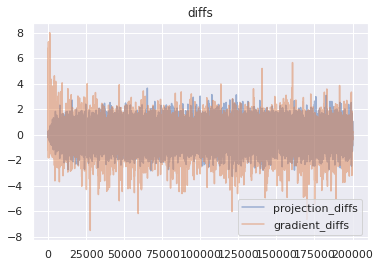

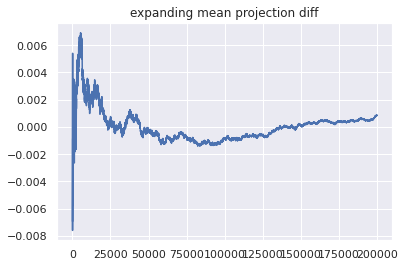

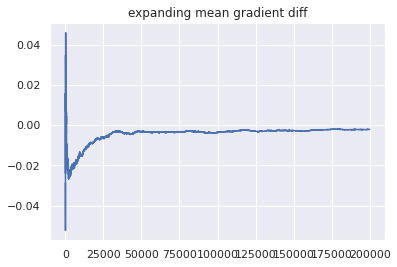

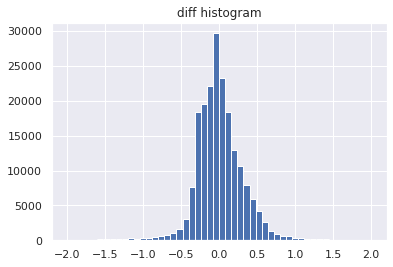

In [ ]:
plt.plot(projection_diffs, label="projection_diffs", alpha=0.5)
plt.plot(gradient_diffs, label="gradient_diffs", alpha=0.5)
plt.title("diffs")
plt.legend(loc="lower right")
plt.show()

plt.plot(pd.Series(projection_diffs).expanding(min_periods=100).mean())
plt.title("expanding mean projection diff")
plt.show()

plt.plot(pd.Series(gradient_diffs).expanding(min_periods=100).mean())
plt.title("expanding mean gradient diff")
plt.show()

plt.hist(gradient_diffs, bins=50, range=(-2, 2))
plt.title("diff histogram")
plt.show()

The more steps we take, the more the average forward gradient approaches the true gradient!

# Implement SGD optimizer

In [ ]:
def optimize_batch(theta_, sizes, batch_x, batch_y, learning_rate, gradient_method):
    gradients = []
    losses = []

    for i, (x, y) in enumerate(zip(batch_x, batch_y)):
        loss, gradient = gradient_method(theta_, sizes, x, y)

        losses.append(loss)
        gradients.append(gradient)

    # average all gradients to get real gradient
    gradient = np.mean(gradients, axis=0)

    # get step
    step = learning_rate * gradient

    # update theta
    new_theta = theta_ - step

    step_size = np.linalg.norm(step, ord=2)
    batch_loss = np.mean(losses)

    return new_theta, batch_loss, step_size

In [ ]:
def optimize(theta, sizes, x_train, y_train, epochs, batch_size, learning_rate, gradient_method):
    epoch_progress = tqdm(range(epochs), unit="epoch", position=1, leave=False)
    for e in epoch_progress:

        losses = []
        # step_sizes = []
        batch_progress = tqdm(range(0, len(x_train), batch_size), unit="batch", position=0, leave=False)
        if len(losses) > 0:
            batch_progress.set_description(f"Batch loss: {losses[-1]:.10f}")

        for j in batch_progress:
            batch_x = x_train[j:j + batch_size]
            batch_y = y_train[j:j + batch_size]

            theta, loss, _step_size = optimize_batch(
                theta, sizes, batch_x, batch_y, learning_rate, gradient_method
            )

            losses.append(loss)
            # step_sizes.append(step_size)

            batch_progress.set_description(f"Batch loss: {loss:.10f}")

        epoch_loss = np.mean(losses)
        epoch_progress.set_description(f"Loss: {epoch_loss:.10f}")

    return theta

# Get MNIST datasets

In [ ]:
!wget https://pjreddie.com/media/files/mnist_train.csv & wget https://pjreddie.com/media/files/mnist_test.csv

--2022-04-19 08:19:25--  https://pjreddie.com/media/files/mnist_train.csv
--2022-04-19 08:19:25--  https://pjreddie.com/media/files/mnist_test.csv
Resolving pjreddie.com (pjreddie.com)... Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
connected.
HTTP request sent, awaiting response... HTTP request sent, awaiting response... 200 OK
Length: 109575994 (104M) [application/octet-stream]
Saving to: ‘mnist_train.csv.1’

mnist_train.csv.1     0%[                    ]       0  --.-KB/s               200 OK
Length: 18289443 (17M) [application/octet-stream]
Saving to: ‘mnist_test.csv.1’

mnist_test.csv.1    100%[===================>]  17.44M  22.6MB/s    in 0.8s    

2022-04-19 08:19:26 (22.6 MB/s) - ‘mnist_test.csv.1’ saved [18289443/18289443]

mnist_train.csv.1   100%[===================>] 104.50M  37.9MB/s    in 2.8s    

2022-04-19 08

In [ ]:
TRAIN = "mnist_train.csv"
TEST = "mnist_test.csv"

train_df = pd.read_csv(TRAIN, header=None)
test_df = pd.read_csv(TEST, header=None)

In [ ]:
train_df.columns = ["label"] + list(range(len(train_df.columns) - 1))
test_df.columns = ["label"] + list(range(len(train_df.columns) - 1))

In [ ]:
train_df.head()

,label,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_df.head()

,label,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


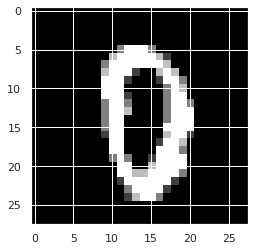

In [ ]:
# display image
def display_image(img: np.array):
    plt.imshow(img.reshape(28, 28), cmap='gray')
    plt.show()

display_image(train_df.drop("label", axis=1).loc[np.random.randint(0, len(train_df))].values)

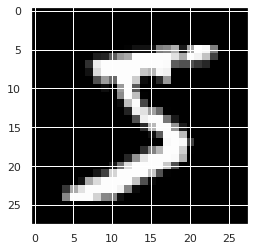

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [ ]:
x_train = train_df.drop("label", axis=1).values
y_train = train_df["label"].apply(lambda l: np.array([1 if l == i else 0 for i in range(10)]))

x_train, y_train = x_train[:10], y_train[:10]

idx = np.random.randint(0, len(x_train))
display_image(x_train[idx])
y_train[idx]

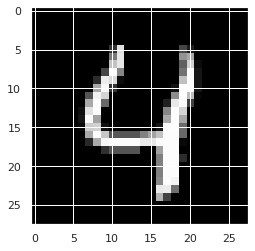

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [ ]:
x_test = test_df.drop("label", axis=1).values
y_test = test_df["label"].apply(lambda l: np.array([1 if l == i else 0 for i in range(10)]))

x_test, y_test = x_test[:10], y_test[:10]

idx = np.random.randint(0, len(x_test))
display_image(x_test[idx])
y_test[idx]

In [ ]:
len(x_train), len(y_train), len(x_test), len(y_test)

(10, 10, 10, 10)

## Build the network

In [ ]:
sizes = 28 * 28, 32, 10
theta = build_theta(sizes)
activation_method = relu
activation_method_d = relu_d
loss_method = cce
loss_method_d = cce_d

# wrap gradient calculation methods
forward_gradient = lambda theta, sizes, x, y: project_forward_gradient(
            theta, sizes, x, y, np.random.normal(0, 1, (len(theta), 1)), activation_method, loss_method
        )
backward_gradient = lambda theta, sizes, x, y: get_backward_gradient(
            theta, sizes, x, y,
            activation_method, loss_method, activation_method_d, loss_method_d
        )

In [ ]:
# for fairness, the back gradient will also use dual numbers
backward_gradient_d_1 = lambda theta, sizes, x, y: get_backward_gradient(
            to_dual_real(theta), sizes, x, y,
            activation_method, loss_method,
            activation_method_d, loss_method_d
        )

backward_gradient_d_2 = lambda loss, gradient: (loss, dual_real(gradient))

backward_gradient_dual = lambda theta, sizes, x, y: backward_gradient_d_2(
    *backward_gradient_d_1(theta, sizes, x, y)
)

# Compare forward gradient speed to backward gradient speed

In [ ]:
%%timeit
forward_gradient(theta, sizes, x_train[0], y_train[0])

1 loop, best of 5: 284 ms per loop


In [ ]:
%%timeit
backward_gradient(theta, sizes, x_train[0], y_train[0])

The slowest run took 7.51 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 5: 1.34 ms per loop


In [ ]:
%%timeit
backward_gradient_dual(theta, sizes, x_train[0], y_train[0])

1 loop, best of 5: 390 ms per loop


# Train using both gradients

In [ ]:
def score(theta, sizes, activation_method, x, y):
    right = 0
    for input_v, expected_output in zip(x, y):
        output = forward(theta, sizes, input_v.reshape(-1, 1), activation_method)
        if output.argmax() == expected_output.argmax():
            right += 1

    return right / len(x) * 100

correct = score(theta, sizes, activation_method, x_test, y_test)
print(f"Initial theta is {correct:.2f}% correct")

Initial theta is 0.00% correct


In [ ]:
forward_theta = np.copy(theta)
backward_theta = np.copy(theta)

# wrap optimize call
optimize_benchmark = lambda theta, grad_method, lr: optimize(
    theta, sizes, x_train, y_train,
    epochs=20, batch_size=10, learning_rate=lr,
    gradient_method=grad_method
)

In [ ]:
# train using backward SGD
backward_theta = optimize_benchmark(backward_theta, backward_gradient, 0.01)
correct = score(backward_theta, sizes, activation_method, x_train, y_train)
print(f"backward_theta is {correct:.2f}% correct")

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

backward_theta is 50.00% correct


In [ ]:
# train using forward SGD
forward_theta = optimize_benchmark(forward_theta, forward_gradient, 0.001)
correct = score(forward_theta, sizes, activation_method, x_train, y_train)
print(f"forward_theta is {correct:.2f}% correct")

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

forward_theta is 10.00% correct


IndexError: ignored

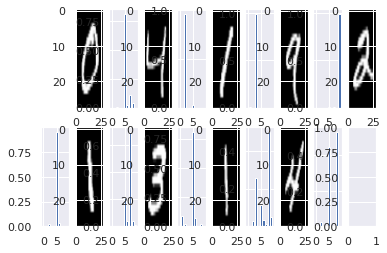

In [ ]:
# f, ax = plt.subplots(2, 10)
%matplotlib inline

for i in range(1, 11):
    plt.subplot(2, 10, i*2).imshow(x_train[i].reshape(28, 28), cmap='gray', aspect='auto')
    plt.subplot(2, 10, i*2 + 1).bar(range(10), softmax(forward(forward_theta, sizes, x_train[i].reshape(-1, 1), activation_method)).flatten())
    # print(f"Certainty of", y_train[1].argmax(), ":", softmax(forward(forward_theta, sizes, x_train[i].reshape(-1, 1), activation_method))[y_train[i].argmax()])
    # ax[1][i].set

plt.tight_layout()
plt.show()

<BarContainer object of 10 artists>

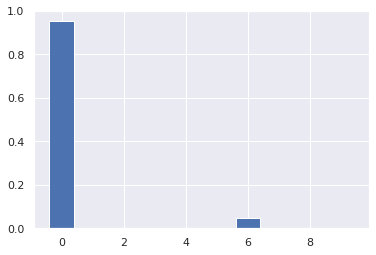